## Metrics of the classification using k-NN with embeddings
`test_index.py`

In [1]:
import json
import pandas as pd

from pathlib import Path
from collections import Counter, namedtuple, defaultdict

from sklearn.metrics import (
    precision_score, 
    recall_score,
    accuracy_score, 
    balanced_accuracy_score
    )


Load data from experiment

In [2]:
PATH_TRAIN=Path("/data/bacteria/experiments/autoencoders/6mer/27122023-5")

# load labels for train+val and test
with open(f"{PATH_TRAIN}/split-train-val-test.json","r") as fp:
    datasets = json.load(fp)


In [3]:
ID_assemblies = [Path(p).stem for p in  datasets["id_labels"]["test"]]
ID_assemblies[:2]

['SAMEA1030444', 'SAMEA3373505']

In [4]:
# collect info in a dataframe
InfoLabels = namedtuple("InfoLabels",["label","dataset","count"])
counts = dict()
data = []
for ds in ["train","val","test"]:
    count = Counter(datasets["labels"][ds])
    for specie, count in count.items():
        data.append(
            InfoLabels(specie, ds, count)
        )

df_infolabels = pd.DataFrame(data)

# get dict with count for the test set for later evaluation
counts_test = dict()
for idx, sp, ds, count in df_infolabels.query("dataset == 'test'").to_records("record"):
    counts_test[sp] = count

counts_train = defaultdict(int)
for idx, sp, ds, count in df_infolabels.query("dataset != 'test'").to_records("record"):
    counts_train[sp] += count

#### load assigned labels by k-NN using embeddings and faiss index
- Columns named `consensus_<k>` correspond to the label assigned by majority vote using the `k` retrieved embeddings for each query.
- The column `GT` correspond to the true label of the query.

In [5]:
df = pd.read_csv(PATH_TRAIN.joinpath("test/test_index.tsv"),sep="\t", index_col=0)
df["ID"] = ID_assemblies
df.head(5)

,GT,consensus_1,consensus_3,consensus_5,consensus_10,0,1,2,3,4,5,6,7,8,9,ID
0,escherichia_coli,escherichia_coli,escherichia_coli,escherichia_coli,escherichia_coli,escherichia_coli,escherichia_coli,escherichia_coli,escherichia_coli,escherichia_coli,escherichia_coli,escherichia_coli,escherichia_coli,escherichia_coli,escherichia_coli,SAMEA1030444
1,neisseria_gonorrhoeae,neisseria_gonorrhoeae,neisseria_gonorrhoeae,neisseria_gonorrhoeae,neisseria_gonorrhoeae,neisseria_gonorrhoeae,neisseria_gonorrhoeae,neisseria_gonorrhoeae,neisseria_gonorrhoeae,neisseria_gonorrhoeae,neisseria_gonorrhoeae,neisseria_gonorrhoeae,neisseria_gonorrhoeae,neisseria_gonorrhoeae,neisseria_gonorrhoeae,SAMEA3373505
2,staphylococcus_aureus,staphylococcus_aureus,staphylococcus_aureus,staphylococcus_aureus,staphylococcus_aureus,staphylococcus_aureus,staphylococcus_aureus,staphylococcus_aureus,staphylococcus_aureus,staphylococcus_aureus,staphylococcus_aureus,staphylococcus_aureus,staphylococcus_aureus,staphylococcus_aureus,staphylococcus_aureus,SAMEA104093527
3,klebsiella_aerogenes,klebsiella_aerogenes,klebsiella_pneumoniae,klebsiella_pneumoniae,klebsiella_pneumoniae,klebsiella_aerogenes,klebsiella_pneumoniae,klebsiella_pneumoniae,klebsiella_pneumoniae,klebsiella_variicola,klebsiella_pneumoniae,klebsiella_pneumoniae,klebsiella_pneumoniae,klebsiella_pneumoniae,klebsiella_pneumoniae,SAMN03074833
4,streptococcus_pyogenes,streptococcus_pyogenes,streptococcus_pyogenes,streptococcus_pyogenes,streptococcus_pyogenes,streptococcus_pyogenes,streptococcus_pyogenes,streptococcus_pyogenes,streptococcus_pyogenes,streptococcus_pyogenes,streptococcus_pyogenes,streptococcus_pyogenes,streptococcus_pyogenes,streptococcus_pyogenes,streptococcus_pyogenes,SAMEA2159852


In [6]:
classes = df.GT.unique()
classes = sorted(classes)
y_true, y_pred = df.GT, df.consensus_10

In [7]:
accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred), len(classes)

(0.9735668531581935, 0.93622775740677, 142)

In [8]:
precision = precision_score(y_true, y_pred, average=None, labels=classes)
recall = recall_score(y_true, y_pred, average=None, labels=classes)

/home/avila/micromamba/envs/train/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
data_metrics = []
Metrics = namedtuple("Metrics", ["label","n_queries", "n_index", "precision","recall"])
for sp, prec, rec in zip(classes, precision, recall):
    n_queries= counts_test[sp]
    n_index = counts_train[sp]
    data_metrics.append(
        Metrics(sp, n_queries, n_index, prec, rec)
    )

In [19]:
df_metrics = pd.DataFrame(data_metrics).sort_values(by=["recall"])
df_metrics.sort_values("label").sort_values(by="precision").head(15)

,label,n_queries,n_index,precision,recall
128,streptococcus_sp_group_b,14,131,0.000000,0.000000
17,brucella_suis,14,126,0.000000,0.000000
16,brucella_melitensis,25,226,0.333333,0.160000
15,brucella_abortus,49,445,0.565789,0.877551
10,bacillus_thuringiensis,24,218,0.684211,0.541667
103,roseburia_hominis,11,98,0.692308,0.818182
45,enterobacter_hormaechei,130,1172,0.722222,0.900000
67,lactococcus_lactis,11,104,0.785714,1.000000
79,mycobacterium_kansasii,22,197,0.791667,0.863636
44,enterobacter_cloacae,120,1081,0.813187,0.616667


In [20]:
df_metrics.describe()

,n_queries,n_index,precision,recall
count,142.000000,142.000000,142.000000,142.000000
mean,86.852113,781.619718,0.945225,0.936228
std,127.203525,1144.772000,0.143192,0.164657
min,10.000000,90.000000,0.000000,0.000000
25%,15.000000,134.500000,0.949343,0.942857
50%,27.500000,243.500000,1.000000,0.995000
75%,69.750000,628.000000,1.000000,1.000000
max,400.000000,3600.000000,1.000000,1.000000


___ 

### Confusion Matrix

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
N_SAMPLES=15

<Figure size 2500x2500 with 0 Axes>

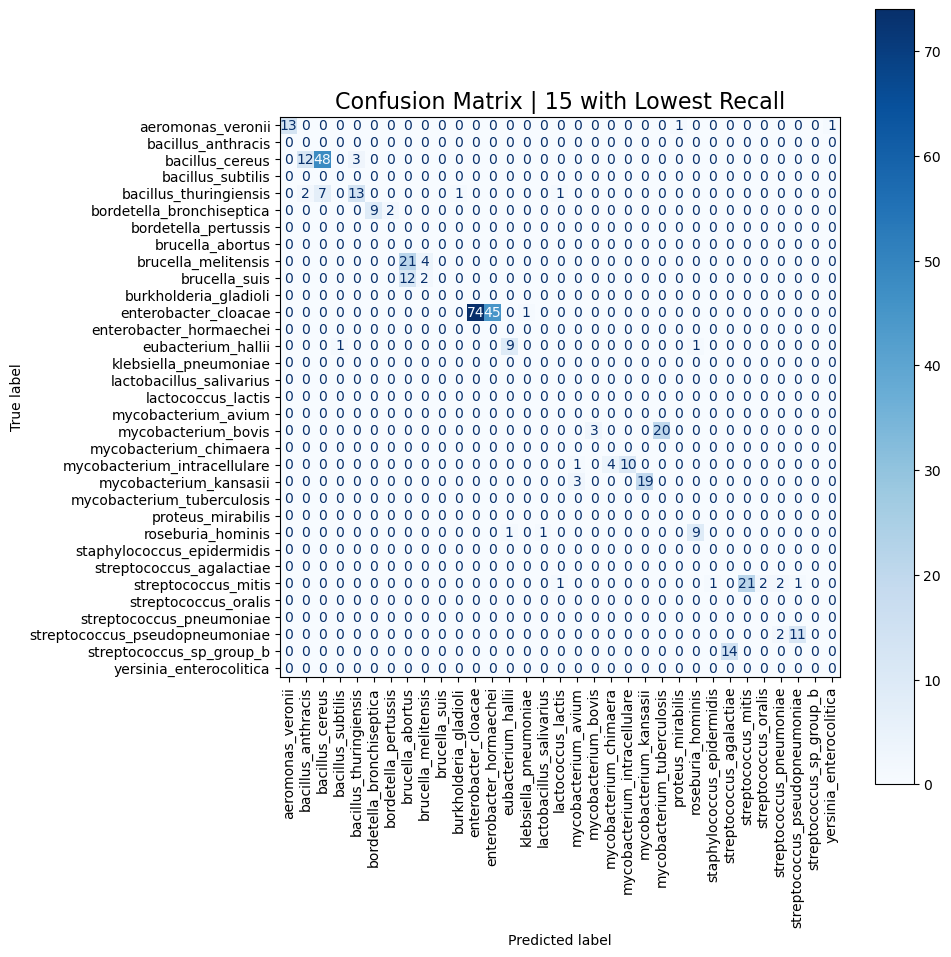

In [30]:

labels_to_plot = df_metrics.sort_values(by="recall")["label"].tolist()[:N_SAMPLES]
filter_df = df.query(f"GT in {(labels_to_plot)}")

y_true = filter_df.GT.tolist()
y_pred = filter_df.consensus_10.tolist()

labels = list(set(y_true+y_pred))
# labels = list(set(y_true))
labels.sort()
fig = plt.figure(figsize=(25,25))
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp=ConfusionMatrixDisplay(cm, display_labels=labels,)

disp.plot( cmap=plt.cm.Blues)
fig = disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(10)  
disp.ax_.set_title(f"Confusion Matrix | {N_SAMPLES} with Lowest Recall", fontsize=16, fontweight="medium")
plt.xticks(rotation='vertical')

PATH_SAVE=Path("../plots/6mers/metrics/confusion_matrix_lowest_recall.png") 
PATH_SAVE.parent.mkdir(exist_ok=True, parents=True)

plt.tight_layout()
plt.savefig(PATH_SAVE,dpi=300)

<Figure size 2500x2500 with 0 Axes>

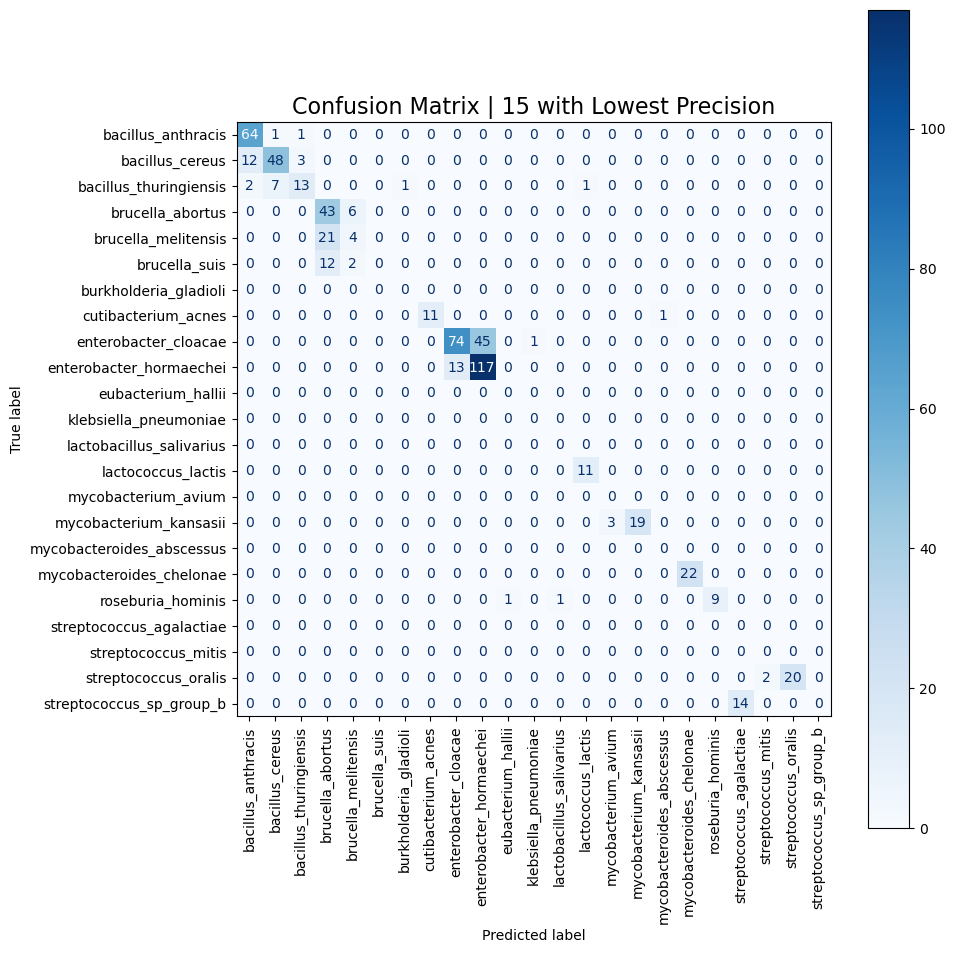

In [29]:
labels_to_plot = df_metrics.sort_values(by="precision")["label"].tolist()[:N_SAMPLES]

filter_df = df.query(f"GT in {(labels_to_plot)}") # and GT != consensus_10")

y_true = filter_df.GT.tolist()
y_pred = filter_df.consensus_10.tolist()

labels = list(set(y_true+y_pred))
# labels = list(set(y_true))

labels.sort()
fig = plt.figure(figsize=(25,25))
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp=ConfusionMatrixDisplay(cm, display_labels=labels,)

disp.plot( cmap=plt.cm.Blues)
fig = disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(10)  
disp.ax_.set_title(f"Confusion Matrix | {N_SAMPLES} with Lowest Precision", fontsize=16, fontweight="medium")
plt.xticks(rotation='vertical')

PATH_SAVE=Path("../plots/6mers/metrics/confusion_matrix_lowest_precision.png") 
PATH_SAVE.parent.mkdir(exist_ok=True, parents=True)

plt.tight_layout()
plt.savefig(PATH_SAVE,dpi=300)

In [139]:
id_missclassified = df[df.GT != df.consensus_10].ID.tolist()

In [137]:
path="/data/bacteria/File1_full_krakenbracken.txt"
krakenbracken = pd.read_csv(path, sep="\t", usecols=["sample_id","V2","V3","V4","V5","V6","V7"])


In [141]:
krakenbracken.query(f"sample_id in {id_missclassified}").sort_values(by="sample_id")

,sample_id,V2,V3,V4,V5,V6,V7
31,SAMD00000812,Escherichia coli,61.075,Shigella dysenteriae,33.268,Salmonella enterica,2.664
152,SAMD00006020,Streptococcus dysgalactiae,10.127,Streptococcus equi,8.438,Streptococcus pyogenes,8.388
524,SAMD00012937,Escherichia coli,76.285,Shigella dysenteriae,9.395,Salmonella enterica,6.835
609,SAMD00013506,Aeromonas hydrophila,25.499,Aeromonas veronii,21.890,Aeromonas salmonicida,9.081
615,SAMD00013657,Escherichia coli,70.700,Shigella dysenteriae,16.332,Pseudomonas aeruginosa,6.156
...,...,...,...,...,...,...,...
621046,SAMN09725650,Mycobacterium bovis,51.831,Mycobacterium tuberculosis,45.459,Mycobacterium sp. 3/86Rv,1.199
621106,SAMN09725710,Mycobacterium bovis,49.842,Mycobacterium tuberculosis,45.271,Mycobacterium canettii,2.268
621153,SAMN09725757,Mycobacterium bovis,50.806,Mycobacterium tuberculosis,45.531,Mycobacterium canettii,1.667
621155,SAMN09725759,Mycobacterium bovis,50.943,Mycobacterium tuberculosis,45.420,Mycobacterium canettii,1.555


In [156]:
df_kraken = krakenbracken.query(f"sample_id in {id_missclassified}").sort_values(by="sample_id",)
df_test = df.query(f"ID in {id_missclassified}")[["GT","consensus_10","ID"]].sort_values(by="ID",)

In [161]:
df_missclassified_abundance = pd.merge(df_test,df_kraken, left_on="ID", right_on="sample_id").sort_values(by="GT")

In [164]:
df_missclassified_abundance["pred_match_second_species"] = df_missclassified_abundance.apply(lambda row: True if row["consensus_10"] == "_".join(row["V4"].lower().split(" ")) else False, axis=1)

In [181]:
df_missclassified_abundance.sort_values(by=["pred_match_second_species","GT","consensus_10"], ascending=False).head(50) #.groupby("pred_match_second_species").count()

,GT,consensus_10,ID,sample_id,V2,V3,V4,V5,V6,V7,pred_match_second_species
117,yersinia_pseudotuberculosis,yersinia_pestis,SAMEA4011275,SAMEA4011275,Yersinia pseudotuberculosis,77.497,Yersinia pestis,19.122,Yersinia similis,1.618,True
116,yersinia_pseudotuberculosis,yersinia_enterocolitica,SAMEA4011243,SAMEA4011243,Yersinia pseudotuberculosis,72.087,Yersinia enterocolitica,18.557,Yersinia pestis,7.170,True
157,yersinia_pestis,yersinia_pseudotuberculosis,SAMN02690732,SAMN02690732,Yersinia pestis,96.188,Yersinia pseudotuberculosis,0.868,Yersinia frederiksenii,0.788,True
115,vibrio_cholerae,bacillus_cereus,SAMEA3903234,SAMEA3903234,Vibrio cholerae,85.068,Bacillus cereus,9.938,Bacillus thuringiensis,4.212,True
220,streptococcus_sp_group_b,streptococcus_agalactiae,SAMN04592782,SAMN04592782,Streptococcus sp. 'group B',70.457,Streptococcus agalactiae,28.609,Streptococcus pyogenes,0.212,True
28,streptococcus_sp_group_b,streptococcus_agalactiae,SAMEA103956222,SAMEA103956222,Streptococcus sp. 'group B',69.248,Streptococcus agalactiae,29.134,Streptococcus uberis,0.403,True
130,streptococcus_sp_group_b,streptococcus_agalactiae,SAMEA4558292,SAMEA4558292,Streptococcus sp. 'group B',80.337,Streptococcus agalactiae,17.339,Streptococcus pyogenes,0.788,True
118,streptococcus_sp_group_b,streptococcus_agalactiae,SAMEA4043887,SAMEA4043887,Streptococcus sp. 'group B',79.876,Streptococcus agalactiae,19.416,Streptococcus pyogenes,0.212,True
254,streptococcus_sp_group_b,streptococcus_agalactiae,SAMN06032973,SAMN06032973,Streptococcus sp. 'group B',63.838,Streptococcus agalactiae,34.507,Streptococcus pyogenes,0.381,True
98,streptococcus_sp_group_b,streptococcus_agalactiae,SAMEA3317625,SAMEA3317625,Streptococcus sp. 'group B',61.610,Streptococcus agalactiae,36.098,Streptococcus anginosus,0.601,True


In [180]:
df_missclassified_abundance.query("pred_match_second_species == False").describe()

,V3,V5,V7
count,118.000000,118.000000,118.000000
mean,48.617169,12.044754,5.818949
std,30.979694,9.769918,4.447123
min,2.027000,0.320000,0.097000
25%,14.473000,5.226750,2.417250
50%,50.183500,9.255500,5.201500
75%,75.224750,15.941750,8.466000
max,98.769000,42.864000,21.154000


In [177]:
df_missclassified_abundance.query("pred_match_second_species == True").describe()

,V3,V5,V7
count,208.000000,208.000000,208.000000
mean,63.084173,22.792183,4.373216
std,20.335447,14.809912,4.172461
min,2.372000,0.868000,0.078000
25%,50.159500,9.563750,0.997000
50%,65.629500,19.605500,3.019500
75%,80.431250,36.591250,6.330500
max,96.188000,48.035000,21.345000
